In [ ]:
# Install transformers library.
#!pip install -q git+https://github.com/huggingface/transformers.git
# Install helper functions.
#!pip install -q git+https://github.com/gmihaila/ml_things.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.1MB 5.0MB/s 
     |████████████████████████████████| 2.9MB 22.3MB/s 
     |████████████████████████████████| 890kB 43.3MB/s 
     |████████████████████████████████| 71kB 4.3MB/s 


# Imports

Import all needed libraries for this notebook.

Declare parameters used for this notebook:

In [ ]:
!pip install sentencepiece
!pip install transformers

     |████████████████████████████████| 1.2MB 13.9MB/s 
     |████████████████████████████████| 2.3MB 14.6MB/s 
     |████████████████████████████████| 901kB 48.9MB/s 
     |████████████████████████████████| 3.3MB 50.7MB/s 


In [ ]:
# Install helper functions.
!pip install -q git+https://github.com/gmihaila/ml_things.git

     |████████████████████████████████| 71kB 7.9MB/s 
     |████████████████████████████████| 10.3MB 18.1MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [ ]:
import io
import os
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import (AutoConfig, 
                          AutoModelForSequenceClassification, 
                          AutoTokenizer, AdamW, 
                          get_linear_schedule_with_warmup,
                          set_seed,
                          )

In [ ]:
import os, sys

print('Importing dataset...')

from google.colab import drive
drive.mount('/content/drive')
os.chdir("drive/My Drive/Stance Detection")

Importing dataset...
Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import tensorflow as tf
import torch
from torch.nn import BCEWithLogitsLoss, BCELoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score
import pickle
import transformers
from tqdm import tqdm, trange
from ast import literal_eval

In [ ]:
# read training data
df = pd.read_csv('./dataset/train.csv')
df.head()

,Party,Tweet,Republican,Democrat,None
0,Democrat,The Student Non-Discrimination Act will put an...,0,1,0
1,Republican,Ready for totality! Taking in #SolarEclipse201...,1,0,0
2,Democrat,Despite Republicans allowing them to go w/o fu...,0,1,0
3,Republican,We have an opportunity to finally gain operati...,1,0,0
4,Democrat,Honored to be included in @NYGovCuomo's #Women...,0,1,0


In [ ]:
df = df[['Tweet', 'Party']]
df.head()

,Tweet,Party
0,The Student Non-Discrimination Act will put an...,Democrat
1,Ready for totality! Taking in #SolarEclipse201...,Republican
2,Despite Republicans allowing them to go w/o fu...,Democrat
3,We have an opportunity to finally gain operati...,Republican
4,Honored to be included in @NYGovCuomo's #Women...,Democrat


In [ ]:
labels_ids = {'Democrat':0, 'None':1, 'Republican':2,}

In [ ]:
!pip uninstall matplotlib
!pip install matplotlib==3.1.3

Uninstalling matplotlib-3.4.2:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.4.2-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.4.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)? y
  Successfully uninstalled matplotlib-3.4.2
     |████████████████████████████████| 13.1MB 6.9MB/s 
ERROR: ml-things 0.0.1 has requirement matplotlib>=3.4.0, but you'll have matplotlib 3.1.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


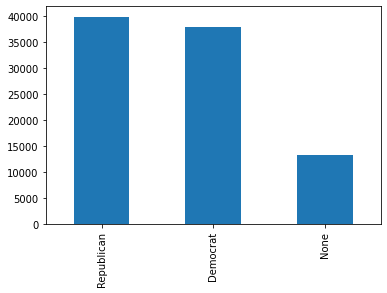

In [ ]:
df['Party'].value_counts().sort_values(ascending=False).plot(kind='bar')

In [ ]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
df['Party'] = LE.fit_transform(df['Party'])
df.head()

,Tweet,Party
0,The Student Non-Discrimination Act will put an...,0
1,Ready for totality! Taking in #SolarEclipse201...,2
2,Despite Republicans allowing them to go w/o fu...,0
3,We have an opportunity to finally gain operati...,2
4,Honored to be included in @NYGovCuomo's #Women...,0


In [ ]:
df.isnull().values.any()

True

In [ ]:
df.isnull().sum()

Tweet    1
Party    0
dtype: int64

In [ ]:
nan_rows = df[df['Tweet'].isnull()]
nan_rows

,Tweet,Party
82066,NaN,1


In [ ]:
df = df.drop([82066])

In [42]:
# Set seed for reproducibility,
set_seed(123)

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Number of batch_size - depending on the max sequence length and GPU memory.
# For 512 sequence length batch of 10 works without cuda memory issues.
# For small sequence length can try batch of 32 or higher.
batch_size = 32

# Padd or truncate text sequences to a specific length
# if `None` it will use maximum sequence of word piece tokens allowed by model.
max_length = 24

# Look for gpu to use. Will use `cpu` by default if no gpu found.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Name of transformers model - will use already pretrained model.
# Path of transformer model - will load your own model from local disk.
model_name_or_path = 'vinai/bertweet-base'

# Dicitonary of labels and their id - this will be used to convert.
# String labels to number.
# labels_ids = {'Republican': 1, 'Democrat': 0, 'None':2}

# How many labels are we using in training.
# This is used to decide size of classification head.
n_labels = len(labels_ids)

In [ ]:
# valid data
test_df = pd.read_csv('./dataset/test.csv')
test_df.head()

,Party,Tweet,Republican,Democrat,None
0,Republican,RELEASE: Small Business Committee Examines Rep...,1,0,0
1,Democrat,Congratulated the 2018 Hampton Roads Chamber o...,0,1,0
2,Republican,"Today, I pushed forward a bipartisan, bicamera...",1,0,0
3,Democrat,#NPWeek Did you know #Hawaii is home to 8 nati...,0,1,0
4,Republican,This past Saturday I spoke at MN Drone Day in ...,1,0,0


In [ ]:
test_df = test_df[['Tweet', 'Party']]
test_df.head()

,Tweet,Party
0,RELEASE: Small Business Committee Examines Rep...,Republican
1,Congratulated the 2018 Hampton Roads Chamber o...,Democrat
2,"Today, I pushed forward a bipartisan, bicamera...",Republican
3,#NPWeek Did you know #Hawaii is home to 8 nati...,Democrat
4,This past Saturday I spoke at MN Drone Day in ...,Republican


In [ ]:
test_df.isnull().values.any()

True

In [ ]:
test_df.isnull().sum()

Tweet    1
Party    0
dtype: int64

In [ ]:
nan_rows = test_df[test_df['Tweet'].isnull()]
nan_rows

,Tweet,Party
4824,NaN,None


In [ ]:
test_df = test_df.drop([4824])

In [ ]:
test_df['Party'] = LE.fit_transform(test_df['Party'])
test_df.head()

,Tweet,Party
0,RELEASE: Small Business Committee Examines Rep...,2
1,Congratulated the 2018 Hampton Roads Chamber o...,0
2,"Today, I pushed forward a bipartisan, bicamera...",2
3,#NPWeek Did you know #Hawaii is home to 8 nati...,0
4,This past Saturday I spoke at MN Drone Day in ...,2


In [ ]:
class Dataset(Dataset):
  r"""PyTorch Dataset class for loading data.

  This is where the data parsing happens and where the text gets encoded using
  loaded tokenizer.

  This class is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.

  Arguments:

    path (:obj:`str`):
        Path to the data partition.
    
    use_tokenizer (:obj:`transformers.tokenization_?`):
        Transformer type tokenizer used to process raw text into numbers.

    labels_ids (:obj:`dict`):
        Dictionary to encode any labels names into numbers. Keys map to 
        labels names and Values map to number associated to those labels.

    max_sequence_len (:obj:`int`, `optional`)
        Value to indicate the maximum desired sequence to truncate or pad text
        sequences. If no value is passed it will used maximum sequence size
        supported by the tokenizer and model.

  """

  def __init__(self, df, use_tokenizer, max_sequence_len=None):

    # Check max sequence length.
    max_sequence_len = use_tokenizer.max_len if max_sequence_len is None else max_sequence_len
    # texts = []
    # labels = []
    print('Reading partitions...')
    # Since the labels are defined by folders with data we loop 
    # through each label.
    texts = list(df.Tweet.values)
    labels = list(df.Party.values)


    # Number of exmaples.
    self.n_examples = len(labels)
    # Use tokenizer on texts. This can take a while.
    print('Using tokenizer on all texts. This can take a while...')
    self.inputs = use_tokenizer(texts, add_special_tokens=True, truncation=True, padding=True, return_tensors='pt',  max_length=max_sequence_len)
    # Get maximum sequence length.
    self.sequence_len = self.inputs['input_ids'].shape[-1]
    print('Texts padded or truncated to %d length!' % self.sequence_len)
    # Add labels.
    self.inputs.update({'labels':torch.tensor(labels)})
    print('Finished!\n')

    return

  def __len__(self):
    r"""When used `len` return the number of examples.

    """
    
    return self.n_examples

  def __getitem__(self, item):
    r"""Given an index return an example from the position.
    
    Arguments:

      item (:obj:`int`):
          Index position to pick an example to return.

    Returns:
      :obj:`Dict[str, object]`: Dictionary of inputs that feed into the model.
      It holddes the statement `model(**Returned Dictionary)`.

    """

    return {key: self.inputs[key][item] for key in self.inputs.keys()}



def train(dataloader, optimizer_, scheduler_, device_):
  r"""
  Train pytorch model on a single pass through the data loader.

  It will use the global variable `model` which is the transformer model 
  loaded on `_device` that we want to train on.

  This function is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.

  Arguments:

      dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

      optimizer_ (:obj:`transformers.optimization.AdamW`):
          Optimizer used for training.

      scheduler_ (:obj:`torch.optim.lr_scheduler.LambdaLR`):
          PyTorch scheduler.

      device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:

      :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss].
  """

  # Use global variable for model.
  global model

  # Tracking variables.
  predictions_labels = []
  true_labels = []
  # Total loss for this epoch.
  total_loss = 0

  # Put the model into training mode.
  model.train()

  # For each batch of training data...
  for batch in tqdm(dataloader, total=len(dataloader)):

    # Add original labels - use later for evaluation.
    true_labels += batch['labels'].numpy().flatten().tolist()
    
    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}
    
    # Always clear any previously calculated gradients before performing a
    # backward pass.
    model.zero_grad()

    # Perform a forward pass (evaluate the model on this training batch).
    # This will return the loss (rather than the model output) because we
    # have provided the `labels`.
    # The documentation for this a bert model function is here: 
    # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
    outputs = model(**batch)

    # The call to `model` always returns a tuple, so we need to pull the 
    # loss value out of the tuple along with the logits. We will use logits
    # later to calculate training accuracy.
    loss, logits = outputs[:2]

    # Accumulate the training loss over all of the batches so that we can
    # calculate the average loss at the end. `loss` is a Tensor containing a
    # single value; the `.item()` function just returns the Python value 
    # from the tensor.
    total_loss += loss.item()

    # Perform a backward pass to calculate the gradients.
    loss.backward()

    # Clip the norm of the gradients to 1.0.
    # This is to help prevent the "exploding gradients" problem.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters and take a step using the computed gradient.
    # The optimizer dictates the "update rule"--how the parameters are
    # modified based on their gradients, the learning rate, etc.
    optimizer.step()

    # Update the learning rate.
    scheduler.step()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()

    # Convert these logits to list of predicted labels values.
    predictions_labels += logits.argmax(axis=-1).flatten().tolist()

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)
  
  # Return all true labels and prediction for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss



def validation(dataloader, device_):
  r"""Validation function to evaluate model performance on a 
  separate set of data.

  This function will return the true and predicted labels so we can use later
  to evaluate the model's performance.

  This function is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.

  Arguments:

    dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

    device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:
    
    :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss]
  """

  # Use global variable for model.
  global model

  # Tracking variables
  predictions_labels = []
  true_labels = []
  #total loss for this epoch.
  total_loss = 0

  # Put the model in evaluation mode--the dropout layers behave differently
  # during evaluation.
  model.eval()

  # Evaluate data for one epoch
  for batch in tqdm(dataloader, total=len(dataloader)):

    # add original labels
    true_labels += batch['labels'].numpy().flatten().tolist()

    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up validation
    with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        # This will return the logits rather than the loss because we have
        # not provided labels.
        # token_type_ids is the same as the "segment ids", which 
        # differentiates sentence 1 and 2 in 2-sentence tasks.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(**batch)

        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple along with the logits. We will use logits
        # later to to calculate training accuracy.
        loss, logits = outputs[:2]
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()
        
        # get predicitons to list
        # predimodel_inputsct_content
        predict_content = logits.argmax(axis=-1).flatten().tolist()

        # update list
        predictions_labels += predict_content

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)

  # Return all true labels and prediciton for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss

# Load Model and Tokenizer

Loding the three esential parts of pretrained transformers: configuration, tokenizer and model. We also need to load model to the device we're planning to use (GPU / CPU).

In [ ]:
!pip install emoji

     |████████████████████████████████| 133kB 15.0MB/s 


In [ ]:
n_labels

3

In [ ]:
# Get model configuration.
print('Loading configuraiton...')
model_config = AutoConfig.from_pretrained(pretrained_model_name_or_path=model_name_or_path, 
                                          num_labels=n_labels)

# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)

# Get the actual model.
print('Loading model...')
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, 
                                                           config=model_config)

# Load model to defined device.
model.to(device)
print('Model loaded to `%s`'%device)

Loading configuraiton...



Loading tokenizer...


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading model...


Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 

Model loaded to `cuda`


# Dataset and DataLoader

Create the PyTorch Dataset and DataLoader objects that will be used to feed data into our model.

In [ ]:
labels_ids

{'Democrat': 0, 'None': 1, 'Republican': 2}

In [ ]:
len(df)

91139

In [ ]:
len(test_df)

10126

In [43]:
print('Dealing with Train...')
# Create pytorch dataset.
train_dataset = Dataset(df, 
                               use_tokenizer=tokenizer, 
                               max_sequence_len=max_length)
print('Created `train_dataset` with %d examples!'%len(train_dataset))

Dealing with Train...
Reading partitions...
Using tokenizer on all texts. This can take a while...
Texts padded or truncated to 24 length!
Finished!

Created `train_dataset` with 91139 examples!


In [44]:
# Move pytorch dataset into dataloader.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))

print()

Created `train_dataloader` with 2849 batches!



In [45]:
# valid - test_df
print('Dealing with ...')
# Create pytorch dataset.
valid_dataset =  Dataset(test_df, 
                               use_tokenizer=tokenizer, 
                               max_sequence_len=max_length)
print('Created `valid_dataset` with %d examples!'%len(valid_dataset))

# Move pytorch dataset into dataloader.
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
print('Created `eval_dataloader` with %d batches!'%len(valid_dataloader))

Dealing with ...
Reading partitions...
Using tokenizer on all texts. This can take a while...
Texts padded or truncated to 24 length!
Finished!

Created `valid_dataset` with 10126 examples!
Created `eval_dataloader` with 317 batches!


In [46]:
# Move pytorch dataset into dataloader.
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
print('Created `eval_dataloader` with %d batches!'%len(valid_dataloader))

Created `eval_dataloader` with 317 batches!


# Train

Create optimizer and scheduler use by PyTorch in training.

Loop through the number of defined epochs and call the **train** and **validation** functions.

Outputs similar info after each epoch as in Keras: *train_loss:  - val_loss:  - train_acc: - valid_acc*.

After training, plot train and validation loss and accuracy curves to check how the training went.



  0%|          | 0/4 [00:00<?, ?it/s]


  0%|          | 0/2849 [00:00<?, ?it/s]


  0%|          | 2/2849 [00:00<04:20, 10.92it/s]

Epoch

Training on batches...





  0%|          | 4/2849 [00:00<04:07, 11.51it/s]


  0%|          | 6/2849 [00:00<03:55, 12.06it/s]


  0%|          | 8/2849 [00:00<03:46, 12.55it/s]


  0%|          | 10/2849 [00:00<03:42, 12.74it/s]


  0%|          | 12/2849 [00:00<03:36, 13.11it/s]


  0%|          | 14/2849 [00:01<03:33, 13.28it/s]


  1%|          | 16/2849 [00:01<03:30, 13.45it/s]


  1%|          | 18/2849 [00:01<03:27, 13.66it/s]


  1%|          | 20/2849 [00:01<03:25, 13.78it/s]


  1%|          | 22/2849 [00:01<03:25, 13.73it/s]


  1%|          | 24/2849 [00:01<03:24, 13.80it/s]


  1%|          | 26/2849 [00:01<03:23, 13.90it/s]


  1%|          | 28/2849 [00:02<03:22, 13.95it/s]


  1%|          | 30/2849 [00:02<03:21, 14.00it/s]


  1%|          | 32/2849 [00:02<03:21, 13.96it/s]


  1%|          | 34/2849 [00:02<03:21, 14.00it/s]


  1%|▏         | 36/2849 [00:02<03:20, 14.01it/s]


  1%|▏         | 38/2849 [00:02<03:21, 13.95it/s]


  1%|▏         | 40/2849 [00:02<03:21, 13.93it/s]


  1%|▏      

Validation on batches...





  4%|▍         | 13/317 [00:00<00:04, 61.72it/s]


  6%|▌         | 19/317 [00:00<00:04, 60.83it/s]


  8%|▊         | 25/317 [00:00<00:04, 59.39it/s]


 10%|▉         | 31/317 [00:00<00:04, 58.17it/s]


 12%|█▏        | 37/317 [00:00<00:04, 57.37it/s]


 14%|█▎        | 43/317 [00:00<00:04, 57.20it/s]


 15%|█▌        | 49/317 [00:00<00:04, 56.97it/s]


 17%|█▋        | 55/317 [00:00<00:04, 56.97it/s]


 19%|█▉        | 61/317 [00:01<00:04, 57.43it/s]


 21%|██        | 67/317 [00:01<00:04, 57.18it/s]


 23%|██▎       | 73/317 [00:01<00:04, 57.05it/s]


 25%|██▍       | 79/317 [00:01<00:04, 57.67it/s]


 27%|██▋       | 86/317 [00:01<00:03, 58.53it/s]


 29%|██▉       | 92/317 [00:01<00:03, 58.35it/s]


 31%|███       | 99/317 [00:01<00:03, 59.31it/s]


 33%|███▎      | 106/317 [00:01<00:03, 59.85it/s]


 35%|███▌      | 112/317 [00:01<00:03, 59.72it/s]


 37%|███▋      | 118/317 [00:02<00:03, 58.66it/s]


 39%|███▉      | 124/317 [00:02<00:03, 58.10it/s]


 41%|████      | 130/317

  train_loss: 0.27948 - val_loss: 0.38076 - train_acc: 0.88407 - valid_acc: 0.84031


Training on batches...





  0%|          | 4/2849 [00:00<03:21, 14.15it/s]


  0%|          | 6/2849 [00:00<03:24, 13.92it/s]


  0%|          | 8/2849 [00:00<03:26, 13.76it/s]


  0%|          | 10/2849 [00:00<03:27, 13.69it/s]


  0%|          | 12/2849 [00:00<03:27, 13.68it/s]


  0%|          | 14/2849 [00:01<03:29, 13.54it/s]


  1%|          | 16/2849 [00:01<03:30, 13.48it/s]


  1%|          | 18/2849 [00:01<03:30, 13.48it/s]


  1%|          | 20/2849 [00:01<03:28, 13.57it/s]


  1%|          | 22/2849 [00:01<03:26, 13.69it/s]


  1%|          | 24/2849 [00:01<03:26, 13.68it/s]


  1%|          | 26/2849 [00:01<03:29, 13.47it/s]


  1%|          | 28/2849 [00:02<03:28, 13.50it/s]


  1%|          | 30/2849 [00:02<03:28, 13.52it/s]


  1%|          | 32/2849 [00:02<03:28, 13.52it/s]


  1%|          | 34/2849 [00:02<03:25, 13.67it/s]


  1%|▏         | 36/2849 [00:02<03:24, 13.73it/s]


  1%|▏         | 38/2849 [00:02<03:25, 13.66it/s]


  1%|▏         | 40/2849 [00:02<03:27, 13.57it/s]


  1%|▏      

Validation on batches...





  4%|▍         | 13/317 [00:00<00:05, 60.48it/s]


  6%|▋         | 20/317 [00:00<00:04, 60.81it/s]


  8%|▊         | 26/317 [00:00<00:04, 59.72it/s]


 10%|█         | 32/317 [00:00<00:04, 57.82it/s]


 12%|█▏        | 38/317 [00:00<00:04, 56.55it/s]


 14%|█▍        | 44/317 [00:00<00:04, 56.30it/s]


 16%|█▌        | 50/317 [00:00<00:04, 56.20it/s]


 18%|█▊        | 56/317 [00:00<00:04, 56.13it/s]


 20%|█▉        | 62/317 [00:01<00:04, 56.74it/s]


 21%|██▏       | 68/317 [00:01<00:04, 55.27it/s]


 23%|██▎       | 74/317 [00:01<00:04, 54.94it/s]


 25%|██▌       | 80/317 [00:01<00:04, 55.02it/s]


 27%|██▋       | 86/317 [00:01<00:04, 55.51it/s]


 29%|██▉       | 92/317 [00:01<00:04, 55.67it/s]


 31%|███       | 98/317 [00:01<00:03, 56.49it/s]


 33%|███▎      | 104/317 [00:01<00:03, 56.05it/s]


 35%|███▍      | 110/317 [00:01<00:03, 57.10it/s]


 37%|███▋      | 117/317 [00:02<00:03, 58.21it/s]


 39%|███▉      | 124/317 [00:02<00:03, 59.29it/s]


 41%|████      | 130/317

  train_loss: 0.20386 - val_loss: 0.43526 - train_acc: 0.91928 - valid_acc: 0.84031


Training on batches...





  0%|          | 4/2849 [00:00<03:28, 13.64it/s]


  0%|          | 6/2849 [00:00<03:30, 13.49it/s]


  0%|          | 8/2849 [00:00<03:33, 13.32it/s]


  0%|          | 10/2849 [00:00<03:34, 13.25it/s]


  0%|          | 12/2849 [00:00<03:35, 13.17it/s]


  0%|          | 14/2849 [00:01<03:35, 13.15it/s]


  1%|          | 16/2849 [00:01<03:35, 13.13it/s]


  1%|          | 18/2849 [00:01<03:32, 13.31it/s]


  1%|          | 20/2849 [00:01<03:31, 13.37it/s]


  1%|          | 22/2849 [00:01<03:30, 13.44it/s]


  1%|          | 24/2849 [00:01<03:33, 13.20it/s]


  1%|          | 26/2849 [00:01<03:34, 13.18it/s]


  1%|          | 28/2849 [00:02<03:34, 13.18it/s]


  1%|          | 30/2849 [00:02<03:32, 13.27it/s]


  1%|          | 32/2849 [00:02<03:31, 13.32it/s]


  1%|          | 34/2849 [00:02<03:29, 13.46it/s]


  1%|▏         | 36/2849 [00:02<03:30, 13.36it/s]


  1%|▏         | 38/2849 [00:02<03:32, 13.23it/s]


  1%|▏         | 40/2849 [00:03<03:30, 13.33it/s]


  1%|▏      

Validation on batches...





  4%|▍         | 13/317 [00:00<00:05, 58.46it/s]


  6%|▌         | 19/317 [00:00<00:05, 58.33it/s]


  8%|▊         | 26/317 [00:00<00:04, 59.05it/s]


 10%|█         | 33/317 [00:00<00:04, 59.55it/s]


 12%|█▏        | 39/317 [00:00<00:04, 59.57it/s]


 14%|█▍        | 45/317 [00:00<00:04, 59.59it/s]


 16%|█▌        | 51/317 [00:00<00:04, 59.65it/s]


 18%|█▊        | 58/317 [00:00<00:04, 60.24it/s]


 20%|██        | 64/317 [00:01<00:04, 60.13it/s]


 22%|██▏       | 71/317 [00:01<00:04, 60.41it/s]


 25%|██▍       | 78/317 [00:01<00:03, 60.66it/s]


 26%|██▋       | 84/317 [00:01<00:03, 59.63it/s]


 28%|██▊       | 90/317 [00:01<00:03, 58.14it/s]


 30%|███       | 96/317 [00:01<00:03, 56.78it/s]


 32%|███▏      | 102/317 [00:01<00:03, 56.47it/s]


 34%|███▍      | 108/317 [00:01<00:03, 57.06it/s]


 36%|███▌      | 114/317 [00:01<00:03, 57.66it/s]


 38%|███▊      | 120/317 [00:02<00:03, 57.35it/s]


 40%|███▉      | 126/317 [00:02<00:03, 57.37it/s]


 42%|████▏     | 133/31

  train_loss: 0.14888 - val_loss: 0.49280 - train_acc: 0.94489 - valid_acc: 0.84318


Training on batches...





  0%|          | 4/2849 [00:00<03:48, 12.44it/s]


  0%|          | 6/2849 [00:00<03:43, 12.70it/s]


  0%|          | 8/2849 [00:00<03:38, 13.00it/s]


  0%|          | 10/2849 [00:00<03:34, 13.23it/s]


  0%|          | 12/2849 [00:00<03:33, 13.29it/s]


  0%|          | 14/2849 [00:01<03:31, 13.40it/s]


  1%|          | 16/2849 [00:01<03:30, 13.48it/s]


  1%|          | 18/2849 [00:01<03:32, 13.32it/s]


  1%|          | 20/2849 [00:01<03:31, 13.37it/s]


  1%|          | 22/2849 [00:01<03:32, 13.31it/s]


  1%|          | 24/2849 [00:01<03:38, 12.95it/s]


  1%|          | 26/2849 [00:01<03:38, 12.93it/s]


  1%|          | 28/2849 [00:02<03:34, 13.16it/s]


  1%|          | 30/2849 [00:02<03:34, 13.16it/s]


  1%|          | 32/2849 [00:02<03:31, 13.35it/s]


  1%|          | 34/2849 [00:02<03:31, 13.32it/s]


  1%|▏         | 36/2849 [00:02<03:33, 13.17it/s]


  1%|▏         | 38/2849 [00:02<03:34, 13.11it/s]


  1%|▏         | 40/2849 [00:03<03:36, 12.96it/s]


  1%|▏      

Validation on batches...





  4%|▍         | 12/317 [00:00<00:05, 58.27it/s]


  6%|▌         | 18/317 [00:00<00:05, 57.61it/s]


  8%|▊         | 24/317 [00:00<00:05, 57.99it/s]


 10%|▉         | 31/317 [00:00<00:04, 58.84it/s]


 12%|█▏        | 38/317 [00:00<00:04, 59.59it/s]


 14%|█▍        | 44/317 [00:00<00:04, 59.40it/s]


 16%|█▌        | 50/317 [00:00<00:04, 57.76it/s]


 18%|█▊        | 56/317 [00:00<00:04, 57.96it/s]


 20%|█▉        | 62/317 [00:01<00:04, 58.31it/s]


 21%|██▏       | 68/317 [00:01<00:04, 55.89it/s]


 23%|██▎       | 74/317 [00:01<00:04, 56.16it/s]


 25%|██▌       | 80/317 [00:01<00:04, 55.47it/s]


 27%|██▋       | 86/317 [00:01<00:04, 56.46it/s]


 29%|██▉       | 93/317 [00:01<00:03, 57.78it/s]


 31%|███       | 99/317 [00:01<00:03, 58.12it/s]


 33%|███▎      | 106/317 [00:01<00:03, 59.08it/s]


 36%|███▌      | 113/317 [00:01<00:03, 59.61it/s]


 38%|███▊      | 119/317 [00:02<00:03, 59.37it/s]


 40%|███▉      | 126/317 [00:02<00:03, 59.94it/s]


 42%|████▏     | 133/317

  train_loss: 0.11748 - val_loss: 0.57346 - train_acc: 0.95895 - valid_acc: 0.83992



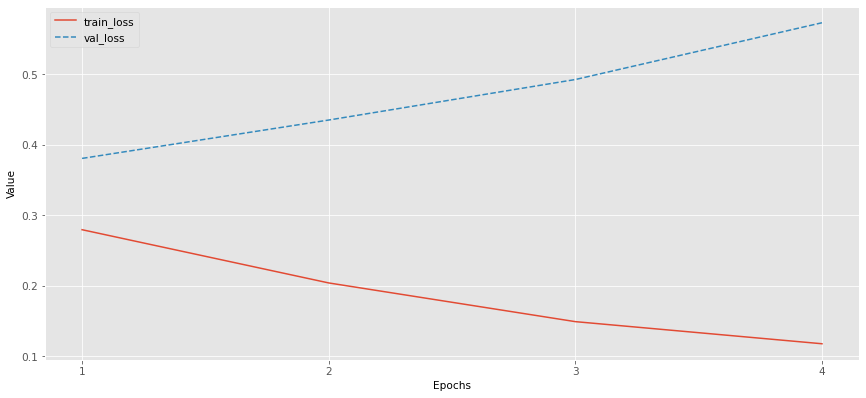

/usr/local/lib/python3.7/dist-packages/ml_things/plot_functions.py:410: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  DeprecationWarning)


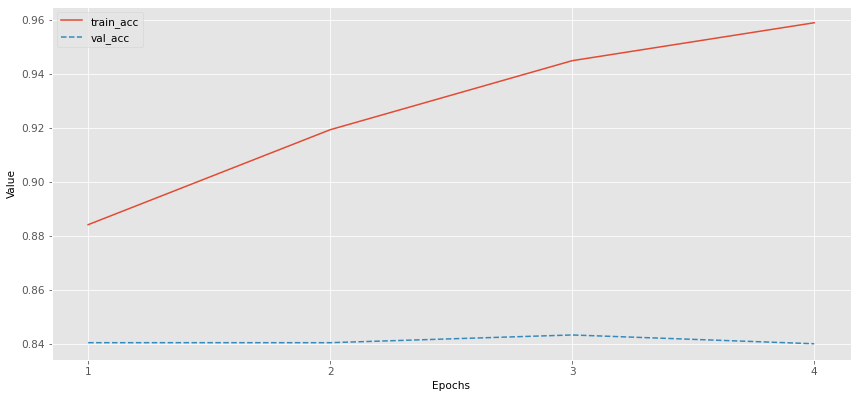

In [47]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  )

# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives 
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Store the average loss after each epoch so we can plot them.
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}

# Loop through each epoch.
print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')
  # Perform one full pass over the training set.
  train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
  train_acc = accuracy_score(train_labels, train_predict)

  # Get prediction form model on validation data. 
  print('Validation on batches...')
  valid_labels, valid_predict, val_loss = validation(valid_dataloader, device)
  val_acc = accuracy_score(valid_labels, valid_predict)

  # Print loss and accuracy values to see how training evolves.
  print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
  print()

  # Store the loss value for plotting the learning curve.
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)

# Plot loss curves.
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

# Plot accuracy curves.
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

In [51]:
# change the max_length
max_length = 100

In [52]:
print('Dealing with Train...')
# Create pytorch dataset.
train_dataset = Dataset(df, 
                               use_tokenizer=tokenizer, 
                               max_sequence_len=max_length)
print('Created `train_dataset` with %d examples!'%len(train_dataset))

# Move pytorch dataset into dataloader.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))

print()

Dealing with Train...
Reading partitions...
Using tokenizer on all texts. This can take a while...
Texts padded or truncated to 100 length!
Finished!

Created `train_dataset` with 91139 examples!
Created `train_dataloader` with 2849 batches!



In [53]:
# valid - test_df
print('Dealing with ...')
# Create pytorch dataset.
valid_dataset =  Dataset(test_df, 
                               use_tokenizer=tokenizer, 
                               max_sequence_len=max_length)
print('Created `valid_dataset` with %d examples!'%len(valid_dataset))

# Move pytorch dataset into dataloader.
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
print('Created `eval_dataloader` with %d batches!'%len(valid_dataloader))

# Move pytorch dataset into dataloader.
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
print('Created `eval_dataloader` with %d batches!'%len(valid_dataloader))

Dealing with ...
Reading partitions...
Using tokenizer on all texts. This can take a while...
Texts padded or truncated to 100 length!
Finished!

Created `valid_dataset` with 10126 examples!
Created `eval_dataloader` with 317 batches!
Created `eval_dataloader` with 317 batches!




  0%|          | 0/4 [00:00<?, ?it/s]


  0%|          | 0/2849 [00:00<?, ?it/s]

Epoch

Training on batches...


Streaming output truncated to the last 5000 lines.
 42%|████▏     | 1184/2849 [03:49<05:30,  5.03it/s]


 42%|████▏     | 1185/2849 [03:50<05:30,  5.04it/s]


 42%|████▏     | 1186/2849 [03:50<05:32,  5.00it/s]


 42%|████▏     | 1187/2849 [03:50<05:29,  5.04it/s]


 42%|████▏     | 1188/2849 [03:50<05:24,  5.12it/s]


 42%|████▏     | 1189/2849 [03:50<05:23,  5.13it/s]


 42%|████▏     | 1190/2849 [03:51<05:32,  4.98it/s]


 42%|████▏     | 1191/2849 [03:51<05:27,  5.07it/s]


 42%|████▏     | 1192/2849 [03:51<05:29,  5.03it/s]


 42%|████▏     | 1193/2849 [03:51<05:24,  5.10it/s]


 42%|████▏     | 1194/2849 [03:51<05:20,  5.16it/s]


 42%|████▏     | 1195/2849 [03:52<05:21,  5.15it/s]


 42%|████▏     | 1196/2849 [03:52<05:25,  5.08it/s]


 42%|████▏     | 1197/2849 [03:52<05:26,  5.06it/s]


 42%|████▏     | 1198/2849 [03:52<05:25,  5.07it/s]


 42%|████▏     | 1199/2849 [03:52<05:22,  5.11it/s]


 42%|████▏     | 1200/2849 [03:53<05:26,  5.05it/s]


 42%|████▏     | 1201/2849 [03:

Validation on batches...





  1%|▏         | 4/317 [00:00<00:17, 18.31it/s]


  2%|▏         | 6/317 [00:00<00:17, 17.89it/s]


  3%|▎         | 8/317 [00:00<00:17, 17.71it/s]


  3%|▎         | 10/317 [00:00<00:17, 17.57it/s]


  4%|▍         | 12/317 [00:00<00:17, 17.45it/s]


  4%|▍         | 14/317 [00:00<00:17, 17.34it/s]


  5%|▌         | 16/317 [00:00<00:17, 17.42it/s]


  6%|▌         | 18/317 [00:01<00:16, 17.70it/s]


  6%|▋         | 20/317 [00:01<00:16, 17.94it/s]


  7%|▋         | 22/317 [00:01<00:16, 17.99it/s]


  8%|▊         | 24/317 [00:01<00:16, 18.07it/s]


  8%|▊         | 26/317 [00:01<00:16, 18.15it/s]


  9%|▉         | 28/317 [00:01<00:15, 18.19it/s]


  9%|▉         | 30/317 [00:01<00:15, 18.22it/s]


 10%|█         | 32/317 [00:01<00:15, 18.22it/s]


 11%|█         | 34/317 [00:01<00:15, 18.17it/s]


 11%|█▏        | 36/317 [00:02<00:15, 17.80it/s]


 12%|█▏        | 38/317 [00:02<00:15, 17.69it/s]


 13%|█▎        | 40/317 [00:02<00:15, 17.60it/s]


 13%|█▎        | 42/317 [00:02<

  train_loss: 0.14290 - val_loss: 0.42852 - train_acc: 0.94711 - valid_acc: 0.85305


Training on batches...


Streaming output truncated to the last 5000 lines.
 42%|████▏     | 1184/2849 [03:51<05:28,  5.08it/s]


 42%|████▏     | 1185/2849 [03:51<05:33,  4.99it/s]


 42%|████▏     | 1186/2849 [03:51<05:30,  5.04it/s]


 42%|████▏     | 1187/2849 [03:52<05:25,  5.11it/s]


 42%|████▏     | 1188/2849 [03:52<05:22,  5.15it/s]


 42%|████▏     | 1189/2849 [03:52<05:21,  5.16it/s]


 42%|████▏     | 1190/2849 [03:52<05:20,  5.18it/s]


 42%|████▏     | 1191/2849 [03:52<05:26,  5.08it/s]


 42%|████▏     | 1192/2849 [03:52<05:22,  5.14it/s]


 42%|████▏     | 1193/2849 [03:53<05:25,  5.09it/s]


 42%|████▏     | 1194/2849 [03:53<05:24,  5.10it/s]


 42%|████▏     | 1195/2849 [03:53<05:28,  5.03it/s]


 42%|████▏     | 1196/2849 [03:53<05:29,  5.01it/s]


 42%|████▏     | 1197/2849 [03:53<05:24,  5.10it/s]


 42%|████▏     | 1198/2849 [03:54<05:23,  5.10it/s]


 42%|████▏     | 1199/2849 [03:54<05:20,  5.15it/s]


 42%|████▏     | 1200/2849 [03:54<05:20,  5.14it/s]


 42%|████▏     | 1201/2849 [03:

Validation on batches...





  1%|▏         | 4/317 [00:00<00:17, 18.11it/s]


  2%|▏         | 6/317 [00:00<00:17, 18.15it/s]


  3%|▎         | 8/317 [00:00<00:16, 18.18it/s]


  3%|▎         | 10/317 [00:00<00:16, 18.20it/s]


  4%|▍         | 12/317 [00:00<00:16, 18.24it/s]


  4%|▍         | 14/317 [00:00<00:16, 18.26it/s]


  5%|▌         | 16/317 [00:00<00:16, 18.27it/s]


  6%|▌         | 18/317 [00:00<00:16, 18.30it/s]


  6%|▋         | 20/317 [00:01<00:16, 18.33it/s]


  7%|▋         | 22/317 [00:01<00:16, 18.31it/s]


  8%|▊         | 24/317 [00:01<00:16, 18.29it/s]


  8%|▊         | 26/317 [00:01<00:15, 18.30it/s]


  9%|▉         | 28/317 [00:01<00:15, 18.32it/s]


  9%|▉         | 30/317 [00:01<00:15, 18.34it/s]


 10%|█         | 32/317 [00:01<00:15, 18.39it/s]


 11%|█         | 34/317 [00:01<00:15, 18.41it/s]


 11%|█▏        | 36/317 [00:01<00:15, 18.43it/s]


 12%|█▏        | 38/317 [00:02<00:15, 18.45it/s]


 13%|█▎        | 40/317 [00:02<00:15, 18.45it/s]


 13%|█▎        | 42/317 [00:02<

  train_loss: 0.10221 - val_loss: 0.57503 - train_acc: 0.96592 - valid_acc: 0.85058


Training on batches...


Streaming output truncated to the last 5000 lines.
 42%|████▏     | 1184/2849 [03:48<05:20,  5.19it/s]


 42%|████▏     | 1185/2849 [03:48<05:18,  5.22it/s]


 42%|████▏     | 1186/2849 [03:48<05:19,  5.21it/s]


 42%|████▏     | 1187/2849 [03:48<05:15,  5.26it/s]


 42%|████▏     | 1188/2849 [03:49<05:15,  5.26it/s]


 42%|████▏     | 1189/2849 [03:49<05:15,  5.27it/s]


 42%|████▏     | 1190/2849 [03:49<05:14,  5.27it/s]


 42%|████▏     | 1191/2849 [03:49<05:14,  5.28it/s]


 42%|████▏     | 1192/2849 [03:49<05:16,  5.23it/s]


 42%|████▏     | 1193/2849 [03:50<05:15,  5.25it/s]


 42%|████▏     | 1194/2849 [03:50<05:15,  5.24it/s]


 42%|████▏     | 1195/2849 [03:50<05:13,  5.28it/s]


 42%|████▏     | 1196/2849 [03:50<05:17,  5.21it/s]


 42%|████▏     | 1197/2849 [03:50<05:17,  5.20it/s]


 42%|████▏     | 1198/2849 [03:51<05:14,  5.25it/s]


 42%|████▏     | 1199/2849 [03:51<05:12,  5.28it/s]


 42%|████▏     | 1200/2849 [03:51<05:09,  5.32it/s]


 42%|████▏     | 1201/2849 [03:

Validation on batches...





  1%|▏         | 4/317 [00:00<00:16, 18.76it/s]


  2%|▏         | 6/317 [00:00<00:16, 18.51it/s]


  3%|▎         | 8/317 [00:00<00:16, 18.49it/s]


  3%|▎         | 10/317 [00:00<00:16, 18.47it/s]


  4%|▍         | 12/317 [00:00<00:16, 18.45it/s]


  4%|▍         | 14/317 [00:00<00:16, 18.47it/s]


  5%|▌         | 16/317 [00:00<00:16, 18.45it/s]


  6%|▌         | 18/317 [00:00<00:16, 18.45it/s]


  6%|▋         | 20/317 [00:01<00:16, 18.44it/s]


  7%|▋         | 22/317 [00:01<00:15, 18.45it/s]


  8%|▊         | 24/317 [00:01<00:15, 18.46it/s]


  8%|▊         | 26/317 [00:01<00:15, 18.46it/s]


  9%|▉         | 28/317 [00:01<00:15, 18.44it/s]


  9%|▉         | 30/317 [00:01<00:15, 18.45it/s]


 10%|█         | 32/317 [00:01<00:15, 18.23it/s]


 11%|█         | 34/317 [00:01<00:15, 18.18it/s]


 11%|█▏        | 36/317 [00:01<00:15, 18.04it/s]


 12%|█▏        | 38/317 [00:02<00:15, 17.96it/s]


 13%|█▎        | 40/317 [00:02<00:15, 18.05it/s]


 13%|█▎        | 42/317 [00:02<

  train_loss: 0.07314 - val_loss: 0.74395 - train_acc: 0.97712 - valid_acc: 0.85285


Training on batches...


Streaming output truncated to the last 5000 lines.
 42%|████▏     | 1184/2849 [03:48<05:24,  5.13it/s]


 42%|████▏     | 1185/2849 [03:48<05:26,  5.09it/s]


 42%|████▏     | 1186/2849 [03:48<05:25,  5.11it/s]


 42%|████▏     | 1187/2849 [03:48<05:23,  5.13it/s]


 42%|████▏     | 1188/2849 [03:48<05:22,  5.16it/s]


 42%|████▏     | 1189/2849 [03:49<05:19,  5.19it/s]


 42%|████▏     | 1190/2849 [03:49<05:17,  5.23it/s]


 42%|████▏     | 1191/2849 [03:49<05:15,  5.26it/s]


 42%|████▏     | 1192/2849 [03:49<05:15,  5.26it/s]


 42%|████▏     | 1193/2849 [03:49<05:16,  5.23it/s]


 42%|████▏     | 1194/2849 [03:49<05:19,  5.19it/s]


 42%|████▏     | 1195/2849 [03:50<05:21,  5.14it/s]


 42%|████▏     | 1196/2849 [03:50<05:19,  5.17it/s]


 42%|████▏     | 1197/2849 [03:50<05:22,  5.13it/s]


 42%|████▏     | 1198/2849 [03:50<05:25,  5.07it/s]


 42%|████▏     | 1199/2849 [03:50<05:19,  5.16it/s]


 42%|████▏     | 1200/2849 [03:51<05:20,  5.15it/s]


 42%|████▏     | 1201/2849 [03:

Validation on batches...





  1%|▏         | 4/317 [00:00<00:16, 18.43it/s]


  2%|▏         | 6/317 [00:00<00:16, 18.30it/s]


  3%|▎         | 8/317 [00:00<00:17, 17.93it/s]


  3%|▎         | 10/317 [00:00<00:17, 17.56it/s]


  4%|▍         | 12/317 [00:00<00:17, 17.76it/s]


  4%|▍         | 14/317 [00:00<00:16, 17.95it/s]


  5%|▌         | 16/317 [00:00<00:16, 18.10it/s]


  6%|▌         | 18/317 [00:01<00:16, 18.20it/s]


  6%|▋         | 20/317 [00:01<00:16, 18.24it/s]


  7%|▋         | 22/317 [00:01<00:16, 18.29it/s]


  8%|▊         | 24/317 [00:01<00:16, 18.30it/s]


  8%|▊         | 26/317 [00:01<00:15, 18.35it/s]


  9%|▉         | 28/317 [00:01<00:15, 18.37it/s]


  9%|▉         | 30/317 [00:01<00:15, 18.39it/s]


 10%|█         | 32/317 [00:01<00:15, 18.39it/s]


 11%|█         | 34/317 [00:01<00:15, 18.42it/s]


 11%|█▏        | 36/317 [00:01<00:15, 18.38it/s]


 12%|█▏        | 38/317 [00:02<00:15, 18.34it/s]


 13%|█▎        | 40/317 [00:02<00:15, 18.31it/s]


 13%|█▎        | 42/317 [00:02<

  train_loss: 0.05407 - val_loss: 0.78403 - train_acc: 0.98528 - valid_acc: 0.85503



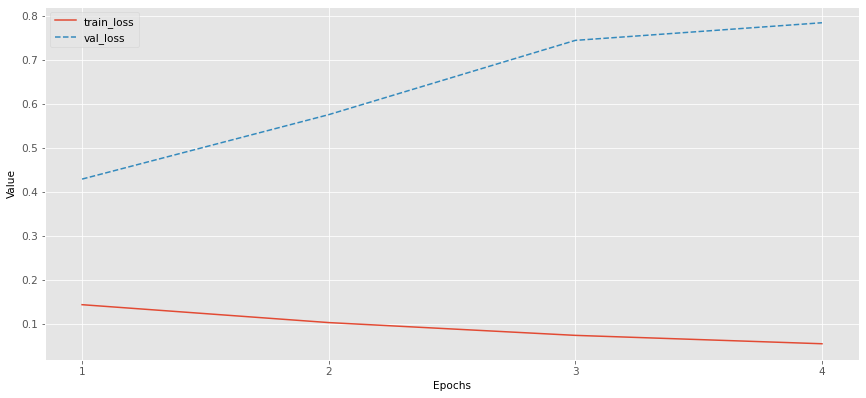

/usr/local/lib/python3.7/dist-packages/ml_things/plot_functions.py:410: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  DeprecationWarning)


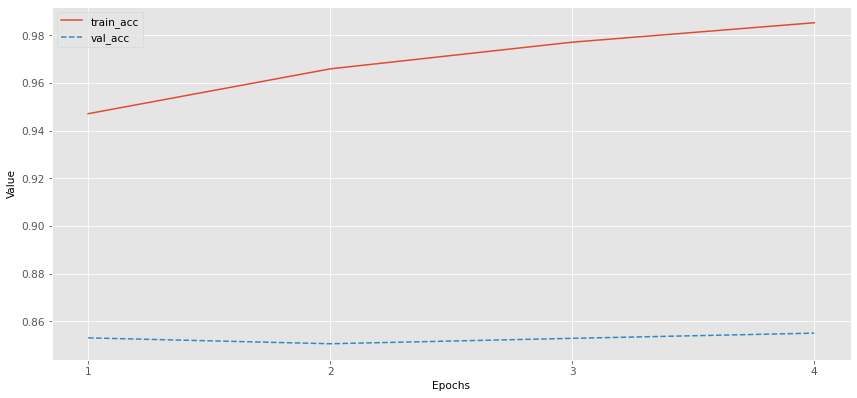

In [54]:
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Store the average loss after each epoch so we can plot them.
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}

# Loop through each epoch.
print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')
  # Perform one full pass over the training set.
  train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
  train_acc = accuracy_score(train_labels, train_predict)

  # Get prediction form model on validation data. 
  print('Validation on batches...')
  valid_labels, valid_predict, val_loss = validation(valid_dataloader, device)
  val_acc = accuracy_score(valid_labels, valid_predict)

  # Print loss and accuracy values to see how training evolves.
  print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
  print()

  # Store the loss value for plotting the learning curve.
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)

# Plot loss curves.
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

# Plot accuracy curves.
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

# Evaluate

When dealing with classification is useful to look at precision recall and F1 score.

A good gauge to have when evaluating a model is the confusion matrix.



  0%|          | 0/317 [00:00<?, ?it/s]

  2%|▏         | 6/317 [00:00<00:05, 56.45it/s]

  4%|▍         | 12/317 [00:00<00:05, 56.10it/s]

  6%|▌         | 18/317 [00:00<00:05, 56.69it/s]

  8%|▊         | 24/317 [00:00<00:05, 57.64it/s]

  9%|▉         | 30/317 [00:00<00:05, 57.03it/s]

 11%|█▏        | 36/317 [00:00<00:04, 57.81it/s]

 13%|█▎        | 42/317 [00:00<00:04, 58.35it/s]

 15%|█▌        | 48/317 [00:00<00:04, 58.76it/s]

 17%|█▋        | 55/317 [00:00<00:04, 59.37it/s]

 20%|█▉        | 62/317 [00:01<00:04, 60.13it/s]

 22%|██▏       | 69/317 [00:01<00:04, 60.56it/s]

 24%|██▎       | 75/317 [00:01<00:04, 60.34it/s]

 26%|██▌       | 81/317 [00:01<00:03, 59.70it/s]

 27%|██▋       | 87/317 [00:01<00:03, 58.37it/s]

 29%|██▉       | 93/317 [00:01<00:03, 58.16it/s]

 31%|███       | 99/317 [00:01<00:03, 57.37it/s]

 33%|███▎      | 106/317 [00:01<00:03, 58.34it/s]

 35%|███▌      | 112/317 [00:01<00:03, 58.81it/s]

 38%|███▊      | 119/317 [00:02<00:03, 59.52it/s]

 40%|

              precision    recall  f1-score   support

    Democrat       0.80      0.81      0.81      4177
        None       0.99      0.98      0.98      1478
  Republican       0.83      0.82      0.82      4471

    accuracy                           0.84     10126
   macro avg       0.87      0.87      0.87     10126
weighted avg       0.84      0.84      0.84     10126

Normalized confusion matrix


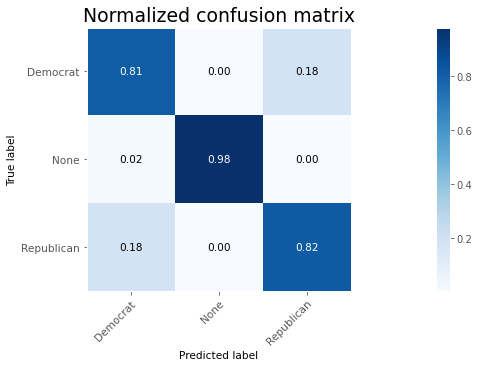

In [48]:
# Get prediction form model on validation data. This is where you should use
# your test data.
true_labels, predictions_labels, avg_epoch_loss = validation(valid_dataloader, device)

# Create the evaluation report.
evaluation_report = classification_report(true_labels, predictions_labels, labels=list(labels_ids.values()), target_names=list(labels_ids.keys()))
# Show the evaluation report.
print(evaluation_report)

# Plot confusion matrix.
plot_confusion_matrix(y_true=true_labels, y_pred=predictions_labels, 
                      classes=list(labels_ids.keys()), normalize=True, 
                      magnify=3,
                      );



  0%|          | 0/317 [00:00<?, ?it/s]

  1%|          | 2/317 [00:00<00:19, 16.27it/s]

  1%|▏         | 4/317 [00:00<00:19, 16.38it/s]

  2%|▏         | 6/317 [00:00<00:18, 16.73it/s]

  3%|▎         | 8/317 [00:00<00:17, 17.18it/s]

  3%|▎         | 10/317 [00:00<00:17, 17.47it/s]

  4%|▍         | 12/317 [00:00<00:17, 17.75it/s]

  4%|▍         | 14/317 [00:00<00:16, 17.93it/s]

  5%|▌         | 16/317 [00:00<00:16, 18.08it/s]

  6%|▌         | 18/317 [00:01<00:16, 18.20it/s]

  6%|▋         | 20/317 [00:01<00:16, 18.28it/s]

  7%|▋         | 22/317 [00:01<00:16, 18.22it/s]

  8%|▊         | 24/317 [00:01<00:16, 18.26it/s]

  8%|▊         | 26/317 [00:01<00:15, 18.19it/s]

  9%|▉         | 28/317 [00:01<00:15, 18.27it/s]

  9%|▉         | 30/317 [00:01<00:16, 17.87it/s]

 10%|█         | 32/317 [00:01<00:15, 17.90it/s]

 11%|█         | 34/317 [00:01<00:15, 18.06it/s]

 11%|█▏        | 36/317 [00:02<00:15, 18.16it/s]

 12%|█▏        | 38/317 [00:02<00:15, 18.13it/s]

 13%|█▎    

              precision    recall  f1-score   support

    Democrat       0.83      0.82      0.82      4177
        None       0.99      1.00      0.99      1478
  Republican       0.83      0.84      0.84      4471

    accuracy                           0.86     10126
   macro avg       0.89      0.89      0.89     10126
weighted avg       0.85      0.86      0.85     10126

Normalized confusion matrix


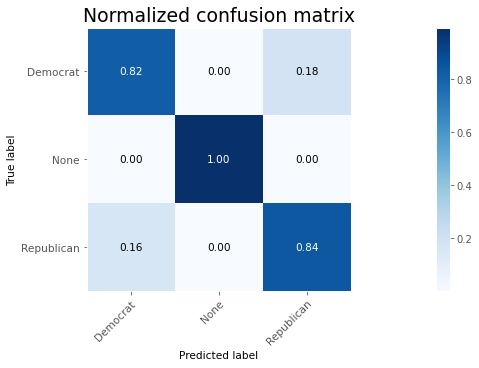

In [55]:
# second results for max_length=100 trial

# Get prediction form model on validation data. This is where you should use
# your test data.
true_labels, predictions_labels, avg_epoch_loss = validation(valid_dataloader, device)

# Create the evaluation report.
evaluation_report = classification_report(true_labels, predictions_labels, labels=list(labels_ids.values()), target_names=list(labels_ids.keys()))
# Show the evaluation report.
print(evaluation_report)

# Plot confusion matrix.
plot_confusion_matrix(y_true=true_labels, y_pred=predictions_labels, 
                      classes=list(labels_ids.keys()), normalize=True, 
                      magnify=3,
                      );